In [10]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorTinguely
from Experiments import Experiment
from plot_experiments import *

horizons = np.linspace(0.001, 0.3, 11)

device = 'cmod'
#dataset = 'random100'
dataset = 'random_256_shots_60%_flattop'
test_dataset = dataset+'_test'

temporal_dataset = '5k_random_256_shots_60%_flattop'
test_temporal_dataset = temporal_dataset+'_test'

# Load models and create disruption predictors

cph_model, cph_transformer, cph_features = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, cph_features, cph_transformer)

cph_temporal_model, cph_transformer, cph_features = load_model('cph', device, temporal_dataset)
cph_temporal_predictor = DisruptionPredictorSM("Cox Proportional Hazards Temporal", cph_temporal_model, cph_features, cph_transformer)
"""
dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

dcm_model, dcm_transformer = load_model('dcm', device, dataset)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, numeric_feats, dcm_transformer)

dsm_model, dsm_transformer = load_model('dsm', device, dataset)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, numeric_feats, dsm_transformer)

rsf_model, rsf_transformer = load_model('rsf', device, dataset)
rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)

ting_model, ting_transformer = load_model('rf', device, dataset)
ting_predictor = DisruptionPredictorTinguely("Tinguely et al. 2019", ting_model, numeric_feats, ting_transformer)
"""
# Create experiments for each predictor
cph_experiment = Experiment(device, test_dataset, cph_predictor, 'CPH')
cph_temporal_experiment = Experiment(device, test_temporal_dataset, cph_temporal_predictor, 'CPH Temporal')
#dcph_experiment = Experiment(device, test_dataset, dcph_predictor, 'DCPH')
#dcm_experiment = Experiment(device, test_dataset, dcm_predictor, 'DCM')
#dsm_experiment = Experiment(device, test_dataset, dsm_predictor, 'DSM')
#rsf_experiment = Experiment(device, test_dataset, rsf_predictor, 'RSF')
#rf_experiment = Experiment(device, test_dataset, rf_predictor, 'RF')
#ting_experiment = Experiment(device, test_dataset, ting_predictor, 'Tinguely')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cph_cmod_random_256_shots_60%_flattop.pkl
Loaded model from models/cph_cmod_5k_random_256_shots_60%_flattop.pkl


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.all_data[predictor.features] = self.feature_data
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.all_data[predictor.features] = self.feature_data
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:37: PerformanceWarning: DataFrame is highly fragme

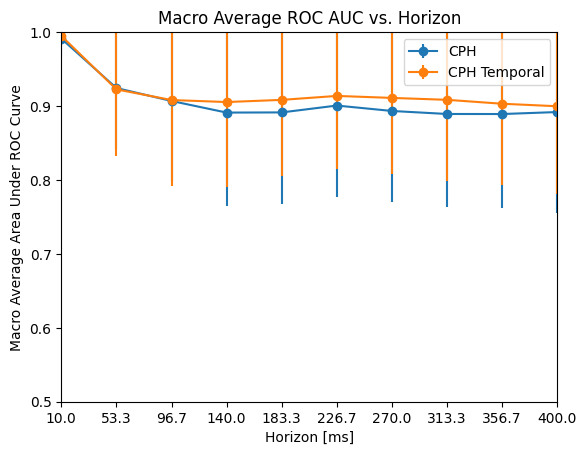

In [11]:
# Run the experiments
#experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, rsf_experiment, rf_experiment, ting_experiment]
#experiment_list = [ting_experiment]
experiment_list = [cph_experiment, cph_temporal_experiment]
plot_roc_auc_vs_horizon_macro(experiment_list)



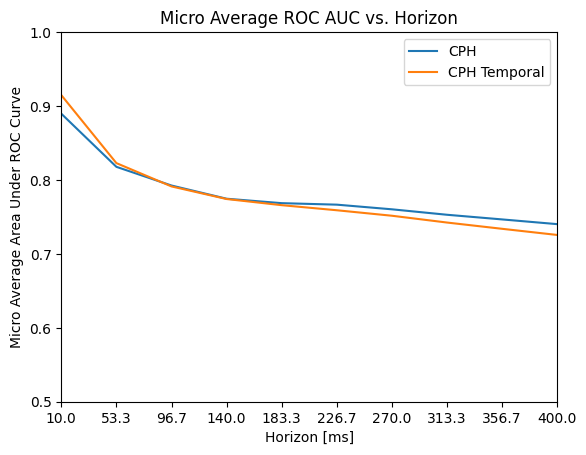

In [12]:
plot_roc_auc_vs_horizon_micro(experiment_list)

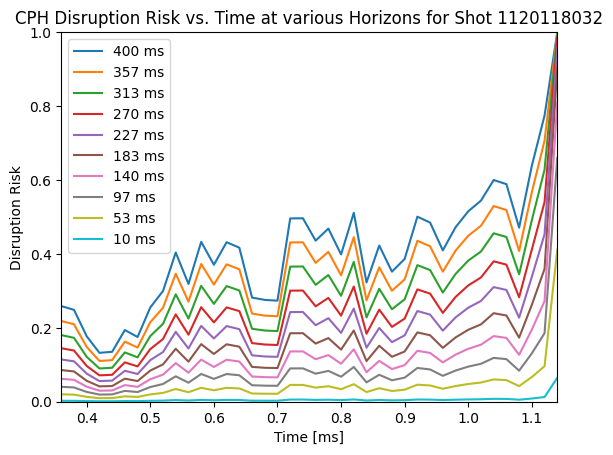

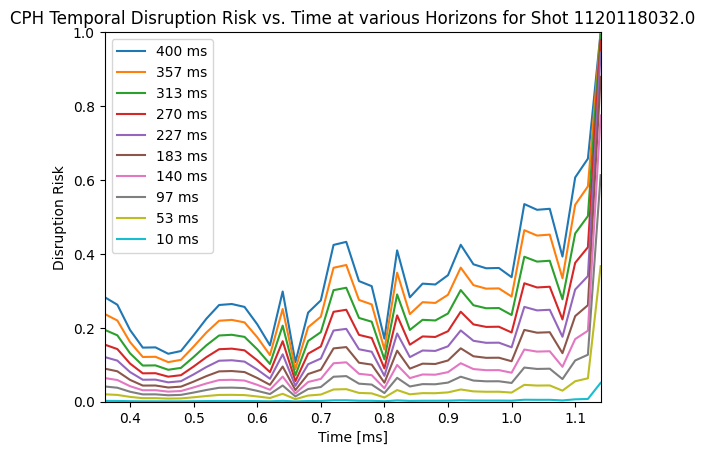

In [13]:
for experiment in experiment_list:
    plot_risk_compare_horizons(experiment, experiment.get_disruptive_shot_list()[1])

In [16]:
plot_warning_time_vs_FPR(experiment_list, 0.1)

ValueError: operands could not be broadcast together with shapes (0,0) (32,) 

<Figure size 640x480 with 0 Axes>